In [ ]:
!pip install sentence_transformers

In [1]:
import os
import pandas as pd

new_path = os.path.split(os.getcwd())[0]

import json
from sentence_transformers import SentenceTransformer, util
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt

load and filter data

In [2]:
bot_direct = pd.read_pickle(os.path.join(new_path,'_data','bot_direct.pkl'))
len(bot_direct)

309107

In [3]:
bot_direct = bot_direct[(~bot_direct['t1_author_location'].isnull())&(~bot_direct['t2_author_location'].isnull())]
len(bot_direct)

76855

In [4]:
bot_direct = bot_direct[bot_direct['t2_year']>2016]
len(bot_direct)

71321

draw 10% random sample of tweets after 2016 where both users have location info available

In [ ]:
pd_sample = bot_direct.sample(int(len(bot_direct)/10))
pd_sample = pd_sample[['t1_id','t2_id','t1_author_id','t2_author_id','t1_text_cleaned','t2_text_cleaned','t1_year','t2_year']]

load actual sample

In [5]:
pd_sample = pd.read_pickle(os.path.join(new_path,'_data','_polarization','pd_sample.pkl'))

In [6]:
len(pd_sample)

7131

augment with location info from googleplaces api

In [7]:
with open(os.path.join(new_path,'_data','_polarization','dict_location.json'), 'r') as f:
    dict_location = json.load(f)

In [8]:
pd_sample.loc[:,'t1_author_country'] = dict_location['t1_location']['country']
pd_sample.loc[:,'t2_author_country'] = dict_location['t2_location']['country']

retain only author-pairs from the us

In [9]:
pd_sample_us = pd_sample[(pd_sample['t1_author_country']=='United States')&(pd_sample['t2_author_country']=='United States')]
pd_sample_us = pd_sample_us.reset_index(drop=True)

In [10]:
len(pd_sample_us)

2670

augment with polarization scores from barbera-method

In [11]:
pd_results_t1 = pd.read_pickle(os.path.join(new_path,'_data','_polarization','pd_polarization_scores.pkl'))

pd_results_t2 = pd_results_t1.copy()
pd_results_t2.columns = ['t2_author_id', 't2_author_polarization']

In [12]:
pd_polarization = pd_sample_us.merge(pd_results_t1, on='t1_author_id', how='left')
pd_polarization = pd_polarization.merge(pd_results_t2, on='t2_author_id', how='left')

pd_polarization = pd_polarization[(~pd_polarization['t1_author_polarization'].isnull())&(~pd_polarization['t2_author_polarization'].isnull())]
pd_polarization = pd_polarization.reset_index(drop=True)

In [13]:
pd_polarization.to_pickle(os.path.join(new_path,'_data','_polarization','pd_polarization.pkl'))

find clusters of accusation contexts

In [14]:
model = SentenceTransformer('all-MiniLM-L6-v2')

In [15]:
tweets = pd_polarization.copy()
tweets = tweets[~tweets['t1_text_cleaned'].isnull()]
tweets = tweets.drop_duplicates('t1_id')

tweets = tweets[['t2_id','t1_text_cleaned']]
tweets['t1_text_final'] = [x.lower() for x in tweets['t1_text_cleaned']]
tweets = tweets.reset_index(drop=True)

corpus_tweets = list(tweets['t1_text_final'])

encode tweets t1

In [16]:
corpus_embeddings = model.encode(corpus_tweets, batch_size=64, show_progress_bar=True, convert_to_tensor=True)

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

find clusters

In [17]:
clusters = util.community_detection(corpus_embeddings, min_community_size=8, threshold=0.4)

process results

In [18]:
def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)
    return tf_idf, count

def extract_top_n_words_per_cluster(tf_idf, count, tweets_per_cluster, n=20):
    words = count.get_feature_names_out()
    labels = list(tweets_per_cluster['cluster'])
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_cluster_sizes(df):
    cluster_sizes = (df.groupby(['cluster'])['tweets'].count().reset_index().rename({'tweets': 'size'}, axis='columns').sort_values('size', ascending=False))
    return cluster_sizes

def create_representative_table(clusters, top_n_words):  
    representative_table = pd.DataFrame({'cluster': [], 'text': []})
    for i, cluster in enumerate(clusters):
        for sentence_id in cluster[0:1]:
            representative_table = pd.concat([representative_table,pd.DataFrame([", ".join([x[0] for x in  top_n_words[i+1]][0:8])], columns=['text'])])
    representative_table['cluster'] = range(1,len(clusters)+1)
    return representative_table

In [19]:
label = 1
lst = [np.nan] * len(corpus_embeddings)
for x in clusters:
    for y in x:
        lst[y] = label
    label = label+1

In [20]:
tweets_df = pd.DataFrame(corpus_tweets, columns=['tweets'])
tweets_df['cluster'] = lst
tweets_df['cluster_id'] = range(len(tweets_df))
tweets_per_cluster = tweets_df.groupby(['cluster'], as_index = False).agg({'tweets': ' '.join})
  
tf_idf, count = c_tf_idf(tweets_per_cluster['tweets'].values, m=len(corpus_tweets))

In [21]:
top_n_words = extract_top_n_words_per_cluster(tf_idf, count, tweets_per_cluster, n=20)
cluster_sizes = extract_cluster_sizes(tweets_df)

show significant tokens per cluster

In [22]:
create_representative_table(clusters,top_n_words)

,cluster,text
0,1,"bot, bots, just, like, twitter, think, lol, ve"
0,2,"trump, biden, president, america, news, people..."
0,3,"obama, maga, president, did, years, just, demo..."
0,4,"exactly, uhh, yeah, lol, really, fault, father..."
0,5,"dems, democrats, news, trump, democrat, amp, w..."
0,6,"trump, president, schiff, herring, breaking, a..."
0,7,"president, best, jobs, lifetime, promises, ame..."
0,8,"masks, vaccinated, covid, virus, numbers, wear..."
0,9,"president, thank, trump, vote, elected, govt, ..."
0,10,"follow, followers, twitter, following, comment..."


In [23]:
all_c = []

for c in clusters:
    all_c.extend(c)

combine different clusters on "politics" and "covid"

In [24]:
cluster_pol = [2,3,5,6,7,9,12,13,15,16,17,20,21,25,27,28]
cluster_cov = [8]

cluster_pol = [i-1 for i in cluster_pol]
cluster_cov = [i-1 for i in cluster_cov]

In [25]:
pos_pol = []
for i in cluster_pol:
    pos_pol.extend(clusters[i])
pos_pol.sort()

pos_cov = []
for i in cluster_cov:
    pos_cov.extend(clusters[i])
pos_cov.sort()

In [26]:
pol_ids = tweets.iloc[pos_pol]['t2_id']
cov_ids = tweets.iloc[pos_cov]['t2_id']

add cluster info to dataframe

In [27]:
pd_polarization['cluster'] = None
pd_polarization.loc[pd_polarization['t2_id'].isin(pol_ids),'cluster'] = 'politics'
pd_polarization.loc[pd_polarization['t2_id'].isin(cov_ids),'cluster'] = 'vaccination / covid'

In [28]:
pd_polarization.to_pickle(os.path.join(new_path,'_data','_polarization','pd_polarization.pkl'))

plot clustered polarization scores

In [29]:
pd_polarization = pd.read_pickle(os.path.join(new_path,'_data','_polarization','pd_polarization.pkl'))

In [30]:
def plot_polarization(pd_scores):
    n_rr = len(pd_scores[(pd_scores['t1_author_polarization']>0)&(pd_scores['t2_author_polarization']>0)])
    n_lr = len(pd_scores[(pd_scores['t1_author_polarization']<0)&(pd_scores['t2_author_polarization']>0)])
    n_rl = len(pd_scores[(pd_scores['t1_author_polarization']>0)&(pd_scores['t2_author_polarization']<0)])
    n_ll = len(pd_scores[(pd_scores['t1_author_polarization']<0)&(pd_scores['t2_author_polarization']<0)])

    s_rr = np.round(n_rr/len(pd_scores),2)
    s_lr = np.round(n_lr/len(pd_scores),2)
    s_rl = np.round(n_rl/len(pd_scores),2)
    s_ll = np.round(n_ll/len(pd_scores),2)
    
    print(f't1_author left, t2_author right: {n_lr} ({s_lr}%)')
    print(f't1_author right, t2_author left: {n_rl} ({s_rl}%)')
    print(f't1_author left, t2_author left: {n_ll} ({s_ll}%)')
    print(f't1_author right, t2_author right: {n_rr} ({s_rr}%)')

    n_pairs = len(pd_scores)
    
    categories = ['politics', 'vaccination / covid']
    colors = ['blue','red']
    
    fig, ax = plt.subplots(figsize=(4,4))
    plt.scatter(pd_scores[pd_scores['cluster'].isnull()]['t1_author_polarization'],pd_scores[pd_scores['cluster'].isnull()]['t2_author_polarization'],marker='+',s=2,c='grey',label='no category')
    for i,cat in enumerate(categories):
        plt.scatter(pd_scores[pd_scores['cluster']==cat]['t1_author_polarization'],pd_scores[pd_scores['cluster']==cat]['t2_author_polarization'],marker='+',s=19,c=colors[i],label=cat)
  
    plt.xlabel('$user_O$ polarization')
    plt.ylabel('$user_A$ polarization')
    plt.legend()
    plt.axvline(x=0,c='black',ls='--',lw=1,alpha=0.2)
    plt.axhline(y=0,c='black',ls='--',lw=1,alpha=0.2)
    
    plt.savefig(os.path.join(new_path,'_results','fig5_polarization_plot.pdf'))
    
    plt.show()

t1_author left, t2_author right: 213 (0.17%)
t1_author right, t2_author left: 546 (0.42%)
t1_author left, t2_author left: 474 (0.37%)
t1_author right, t2_author right: 53 (0.04%)


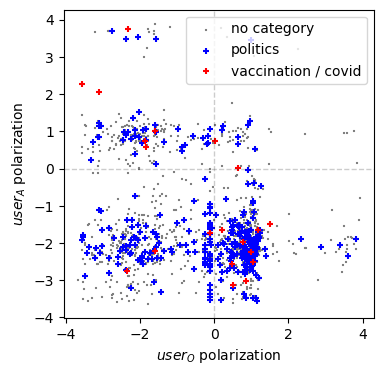

In [31]:
pd_scores = pd_polarization.copy()
plot_polarization(pd_scores)